In [10]:
import ExpControl
import scraps as scr
import numpy as np

In [11]:
wrap = ExpControl.ScrapsWrapper()

#Path to data (you should look and see what it looks like)
dataPath = 'data/XBand_Braggs/2019_11_08_10min_etch/'

#Define a resonator name. The data folder has data for RES-1, RES-2, RES-3, RES-4 so any of those will work.
#Try changing the name to one of the others and rerun the notebook.
resName = 'ETCH-NBND-1um'

#We pass the process file and the path to the data, and the built-in routine spits out a list of Resonator objects!
resList = scr.makeResList(scr.process_file, dataPath, resName, skiprows=1)

#Create index vectors for all temps and pwrs in the experiment

#itemp = temp rounded to the nearest 5 mK
tempsList = np.unique([res.temp for res in resList])
pwrsList = np.unique([res.pwr for res in resList])

#Let's look at all the temperatures and powers in the experiment
print('number of resonators in list = ', len(resList))
print('temps = ', tempsList)
print('powers = ', pwrsList)
print('temps x powers = ', len(tempsList)*len(pwrsList))

number of resonators in list =  99
temps =  [ 1.632  1.643  1.656  1.669  1.698  1.732  1.775  1.818  4.014]
powers =  [-55. -50. -45. -40. -35. -30. -25. -20. -15. -10.  -5.]
temps x powers =  99


In [12]:
for res in resList:
    #Load in the params
    res.load_params(scr.cmplxIQ_params)

    #Do the fit
    res.do_lmfit(scr.cmplxIQ_fit)

In [14]:
from matplotlib import pyplot as plt
plt.show()

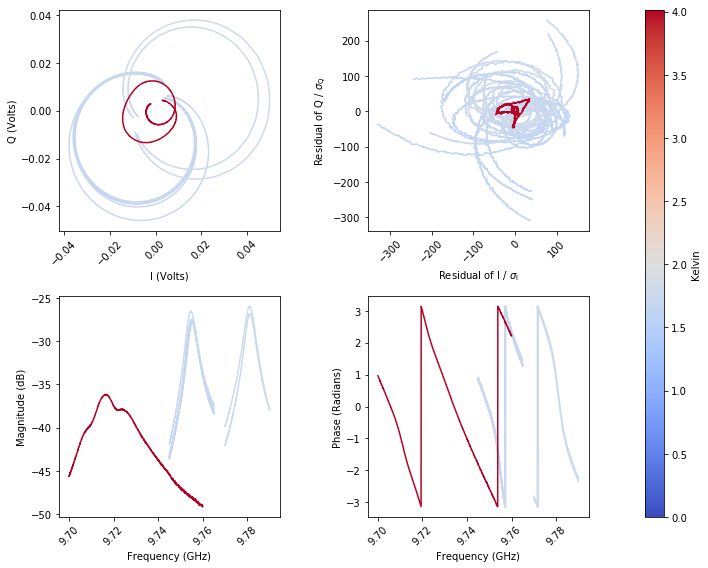

In [17]:
figA = scr.plotResListData(resList,
                            plot_types=['IQ', #Real vs Imaginary part of S21
                                        'rIQ', #residual of fits in IQ plane
                                        'LogMag', #Magnitude of S21 vs frequency
                                        'Phase'], #Phase of S21 vs frequency
                            color_by='temps',
                            fig_size=4,
                            powers=[-20],
                            num_cols = 2,
                            force_square = True,
                            plot_fits = [False]*4) #<-- need to specify a boolean for each plot type
plt.show()

In [18]:
#Pack all of the fit data into resSweep, and use the 'block' index method
#to figure out which temperatures are nominally the same
resSweep = scr.ResonatorSweep(resList, index='block')

#Look at the first few frequencies:
print('\nf0\n',resSweep['f0'].head())

#and the first few reduced-chi-squared values
print('\nredchi\n',resSweep['redchi'].head())


f0
                -55.0         -50.0         -45.0         -40.0         -35.0  \
1632.0  9.759810e+09  9.759726e+09  9.759684e+09  9.759723e+09  9.759761e+09   
1643.0  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09   
1656.0  9.746000e+09  9.746335e+09  9.746000e+09  9.746000e+09  9.746000e+09   
1669.0  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09   
1698.0  9.764000e+09  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09   

               -30.0         -25.0         -20.0         -15.0         -10.0  \
1632.0  9.759760e+09  9.759661e+09  9.760099e+09  9.760403e+09  9.761726e+09   
1643.0  9.746000e+09  9.746000e+09  9.764000e+09  9.746000e+09  9.764000e+09   
1656.0  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09   
1669.0  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09  9.746000e+09   
1698.0  9.746000e+09  9.764000e+09  9.746000e+09  9.746000e+09  9.746000e+09   

               -5.0   
1632.0  9.

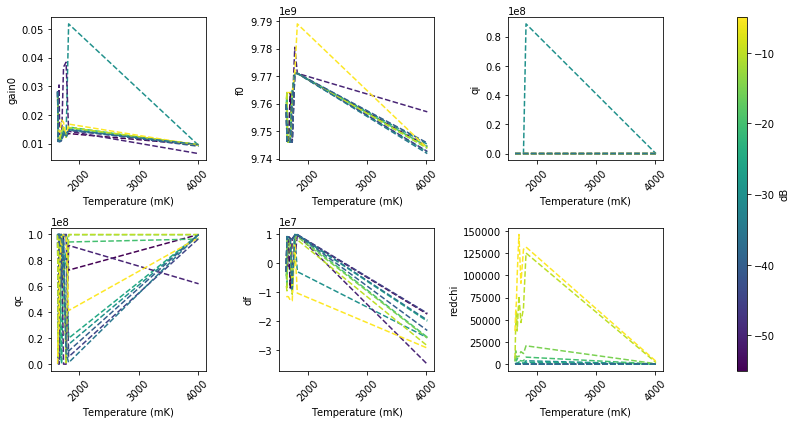

In [19]:
figS = scr.plotResSweepParamsVsX(resSweep,
                                   plot_keys=['gain0', 'f0', 'qi', 'qc', 'df', 'redchi'],
                                   num_cols = 3,
                                   xvals='temperature')
plt.show()

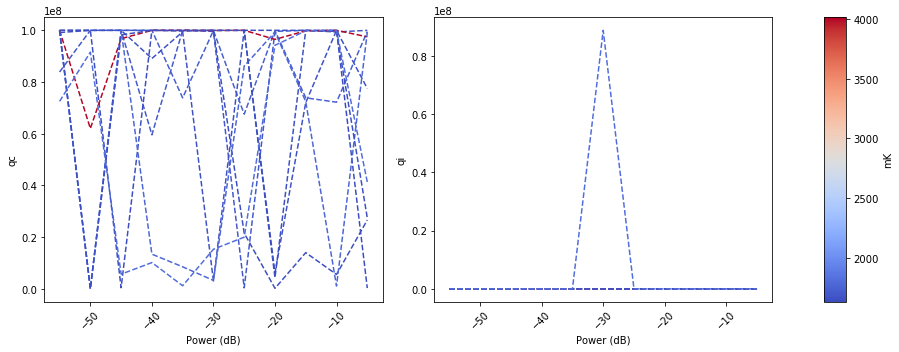

In [20]:
figS2 = scr.plotResSweepParamsVsX(resSweep,
                                   plot_keys=['qc', 'qi'],
                                   fig_size = 5,
                                   xvals='power')
plt.show()

# Nice Figures

In [1]:
import ExpControl
import scraps as scr
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Path to data (you should look and see what it looks like)
dataPath = 'data/XBand_Braggs/2019_11_08_10min_etch/npts201/'

resNames = ['ETCH-NBND-1um']

resLists = {}
for resName in resNames:
    resLists[resName] = scr.makeResList(scr.process_file,
                                        dataPath,
                                        resName,
                                        skiprows=1, delimiter='\t')

In [4]:
#Loop through the dict, and then through each list and
#run lmfit on each S21 transmission data trace
for resName in resNames:
    for res in resLists[resName]:
        if res.pwr < -60:
            #Apply a filter to the data before
            #guessing parameters for low-power measuremnts
            res.load_params(scr.cmplxIQ_params,
                            use_filter=True)
        else:
            res.load_params(scr.cmplxIQ_params,
                            use_filter=False)

        res.do_lmfit(scr.cmplxIQ_fit)
        #You can uncomment this line to run the
        #MCMC sampler on each resonator.
        #This will probably take several hours.
#         res.do_emcee(scr.cmplxIQ_fit,
#                      nwalkers = 30,
#                      steps = 1000,
#                      burn=200)

In [5]:
#Save resLists to a pickle file for easy loading later.
#This is useful for caching data after you have run fits
#that take a long time.
import os
import pickle
fName = 'ETCH-NBND-1um_saved_data.pickle'
fPath = os.path.join('./', fName)

with open(fPath, 'wb') as f:
    pickle.dump(resLists, f, 2)

print('last saved file was: '+fName)

last saved file was: ETCH-NBND-1um_saved_data.pickle


In [6]:
#Load resLists from a pickle file
fName = './ETCH-NBND-1um_saved_data.pickle'
with open(fName, 'rb') as f:
    resLists = pickle.load(f)

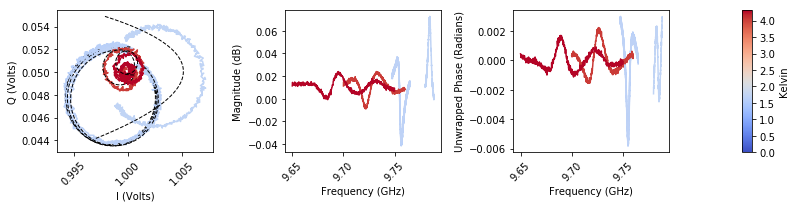

In [7]:
fig1a = scr.plot_tools.plotResListData(resLists['ETCH-NBND-1um'],
                            plot_types=['IQ', 'LogMag', 'uPhase'],
                            detrend_phase = True,
                            plot_fits = [True, False, False],
                            color_by='temps',
                            num_cols = 3,
                            fig_size=3,
                            powers = [-50],
                            #the fit defaults to a thick dashed line. Small plots are nicer with a thinner line
                            fit_kwargs={'linestyle':'--', 'color':'k', 'linewidth':1})
plt.show()

In [8]:
#Get the index of the resonator at the highest temperature and
#the lowest power
t_max = max([res.temp for res in resLists['ETCH-NBND-1um'] if res.pwr == -75])

#rix just stands for resonator index
rix = scr.indexResList(resLists['ETCH-NBND-1um'], t_max, -75)

#Run the MCMC sampler and use the best-fit values from the
#least-squares routine as starting positions
#The first 300 samples from each chain are
#discarded to allow for burn-in
resLists['ETCH-NBND-1um'][rix].do_emcee(scr.cmplxIQ_fit,
                                nwalkers = 30,
                                steps = 1000,
                                burn=200)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Public\Anaconda\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:22<00:00, 45.11it/s]


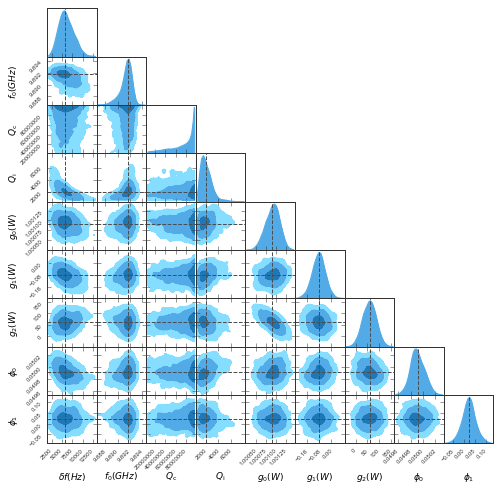

In [9]:
import pygtc
#Make a copy of the MCMC chain so that we
#can modify the units before plotting
mcmc_chain = resLists['ETCH-NBND-1um'][rix].chain.copy()

#Change the frequency units from Hz to GHz
mcmc_chain.T.iloc[1]/=1e9

#pygtc will automatically get labels from
#parameter names, but it is nicer to define them
#because we can use LaTex to make them pretty
labels = ['$\delta f (Hz)$',
            '$f_0 (GHz)$',
            '$Q_\mathrm{c}$',
            '$Q_\mathrm{i}$',
            '$g_0 (W)$',
            '$g_1 (W)$',
            '$g_2 (W)$',
            '$\phi_0$',
            '$\phi_1$']

#Copy the best-fit values from the least-squares
#routine so we can modify the units
least_squares_fit_vals = resLists['ETCH-NBND-1um'][rix].lmfit_result['default']['values']

#Change the frequency units from Hz to GHz
least_squares_fit_vals[1]/=1e9

#Call pygtc to make the figure
fig1b = pygtc.plotGTC(mcmc_chain,
                       truths=least_squares_fit_vals,
                       paramNames=labels,
                       GaussianConfLevels=True,
                       nConfidenceLevels=3,
                       figureSize=8)

#Uncomment to save the figure
#fig1b.savefig('fig1b.pdf')
plt.show()

In [14]:
#(one for each name).

#Each of these objects will be a dict of pandas DataFrames
#We will ignore anything with a readout power below -70 dBm since
#we happen to know that data is all bad!
resSweeps = {}
for resName, resList in resLists.items():
    resSweeps[resName] = scr.ResonatorSweep([res for res in resList if res.pwr > -80], index='block')

#Look at the uncertainties on the best-fit frequencie
#for the first few files of 'RES-1'
resSweeps['ETCH-NBND-1um']['f0_sigma'].head()

,-75.0,-70.0,-65.0,-60.0,-55.0,-50.0,-45.0,-40.0,-35.0,-30.0,-25.0,-20.0,-15.0
1623.0,1.305607e+05,64850.577676,35280.845223,20748.234780,12669.466812,8584.247083,6844.775798,6599.018366,6419.756074,5691.894299,6920.729297,8467.282935,NaN
1639.0,1.054603e+05,68161.981986,35895.710018,20986.662787,13335.634156,8993.051493,7131.125646,6521.890768,6207.670721,6519.466637,6915.517393,8176.710274,NaN
1666.0,1.175023e+05,61747.190640,35048.020564,20768.184827,12721.831498,8487.524133,6897.822674,6033.809429,5924.764055,5987.166931,5986.490334,6874.890486,NaN
1697.0,9.535609e+04,64638.111673,37145.704827,21741.063846,12367.645365,8200.576376,6414.100102,5485.878800,5487.320074,5368.979270,5968.015927,8310.792389,NaN
1733.0,9.013512e+11,122337.504346,NaN,NaN,NaN,NaN,31744.781860,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
fig1c = scr.plotResSweepParamsVsX(resSweeps['ETCH-NBND-1um'],
        xvals = 'temperature',
        fig_size = 3,
        plot_keys = ['f0', 'qi'],
        plot_labels = ['$f_0$ (GHz)',
                       '$Q_\mathrm{i}$'],
        unit_multipliers = [1e-9, 1],
        num_cols = 1,
        powers = [-20,-25,-30,-35,-40,-45,-50,-55,-60,-65,-70,-75],
        force_square=True)
#Uncomment to save the figure
#fig1c.savefig('fig1c.pdf')
plt.show()

AssertionError: index must be 'block' for plotting to work.

In [53]:
import matplotlib.gridspec as gs
import matplotlib as mpl
def plotResSweepParamsVsX(resSweep, plot_keys=None, ignore_keys=None, xvals='temperature', **kwargs):
    r"""Plot parameter data vs temperature from a ResonatorSweep object.
    Parameters
    ----------
    resSweep : ``scraps.ResonatorSweep`` object or list of objects
        The object containing the data you want to look at. It is also possible
        to pass a list of these objects and it will combine them into one plot.
    plot_keys : list-like (optional)
        A list of strings corresponding to avaiable plot data. The available
        keys depend on your parameter definitions and may be found by executing
        ``print(resSweep.keys())``. Some keys may point to empty (NaN) objects.
        Default is to plot all of the keys that exist. If you pass plot_keys
        you may not pass ignore_ignore keys.
    ignore_keys : list-like (optional)
        A list of strings corresponding to plots that should not be made. This
        is useful if you want to plot most of the avaialble data, but ignore one
        or two sets of data. Default is ``None``. If you pass ignore_keys you
        may not pass plot_keys.
    xvals : string
        What axis you want to plot by. Deafult is 'temperature'. Could also be
        'power'. Future releases may include other options.
    color_by : string
        Set this to 'index' if you pass multiple res sweeps and want to color them by index.
    Keyword Arguments
    -----------------
    plot_labels : list-like
        A list of strings to use to label the y-axes of the plots. There must be
        one for each plot requested. ``None`` is acceptable for any position in
        the list and will default to using the key as the label. Default is to
        use the key as the label.
    unit_multipliers : list-like
        A list of numbers to multiply against the y-axes data. There must be one
        for each plot requested. ``None`` is acceptable for any position in the
        list and will default to 1. Default is 1.
    fitter : string {'lmfit', 'emcee'}
        Which fit data to use when overlaying best fits. Default is 'lmfit'.
    num_cols : int
        The number of columns to create in the plot grid. Default is 1. The
        number of rows will be calculated based on num_cols and the number of
        requested plots.
    powers : list
        List of powers to plot. Default is to plot all available. If xvals is
        'power' this kwarg is ignored.
    temperatures : list
        List of temperatures to plot. Default is to plot all available. If xvals
        is 'temperature' this kwarg is ignored.
    xmax : numeric
        Don't plot any xvals above this value. Default is infinity.
    xmin : numeric
        Don't plot any xvals below this value. Default is 0 for temperature and
        -infinity for power.
    errorbars: {None, 'lmfit', 'emcee'}
        Add error bars to the data. Pulls from either the least-squares or the
        MCMC fits. Default is None.
    fig_size : numeric
        Size in inches for each plot in the figure.
    color_map : string
        Specifies the colormap to use. Any value in ``matplotlib.pyplot.colormaps()``
        is a valid option.
    show_colorbar : {True, False}, optional
        Whether or not to add a colorbar to the right edge of the figure. The
        colorbar will correspond to the limits of the colored data. Default is
        True.
    force_square : bool
        Whether or not to force each subplot to have perfectly square axes.
    plot_kwargs : dict or list of dicts
        Dict of keyword args to pass through to the plotting function. Default
        is {'linestyle':'--', label='Power X dB'}. If errorbars is not None,
        then default linestyle is {'linestyle':'o'}. Attempting to set 'color'
        or 'yerr' will result in an exception. Use the color_map and errorbars
        keywords to set those. If you passed in a list of objects to resSweep,
        then you can also pass a list of plot_kwargs, one for each sweep object.
    """

    if type(resSweep) is not list:
        resSweep = [resSweep]

    for rS in resSweep:
        rS.smartindex = 'block'
        print(rS.smartindex)

        #This will really only work for sure if block is sucessful
        #assert rS.smartindex == 'block', "index must be 'block' for plotting to work." #<----------
        #TODO: fix for other smartindex types

    #set defaults
    plot_labels = kwargs.pop('plot_labels', None)

    unit_multipliers = kwargs.pop('unit_multipliers', None)

    #Which fit data should be plot? lmfit or emcee?
    fitter = kwargs.pop('fitter', 'lmfit')

    #Number of columns
    num_cols = int(kwargs.pop('num_cols', 4))

    #Powers to plot
    powers = list(kwargs.pop('powers', []))

    #Temperatures to plot
    temps = list(kwargs.pop('temps', []))

    if xvals == 'temperature':
        #Just use all the powers that exist period!
        if len(powers) == 0:
            for rS in resSweep:
                powers.extend(rS.pvec)
            powers = list(set(powers))
        else:
            for rS in resSweep:
                assert any(p in rS.pvec for p in powers), "No data exists at any requested power."

    if xvals == 'power':
        #Just use all the temperatures that exist period!
        if len(temps) == 0:
            for rS in resSweep:
                temps.extend(rS.tvec)
            temps = list(set(temps))
        else:
            for rS in resSweep:
                assert any(t in rS.tvec for t in temps), "No data exists at any requested temperature."

    #Set up the x-axis mask
    xmax = kwargs.pop('xmax', None)
    xmin = kwargs.pop('xmin', None)

    if xmin is None:
        if xvals == 'temperature':
            xmin = 0
        elif xvals == 'power':
            xmin = -np.inf

    #Just use the biggest temperature in any set if max isn't passed
    if xmax is None:
        xmax = np.inf

    xMask = []
    for rS in resSweep:
        if xvals == 'temperature':
            xvec = rS.tvec
        elif xvals == 'power':
            xvec = rS.pvec
        xMask.append((xvec >= xmin) * (xvec <= xmax))

    color_by = kwargs.pop('color_by', None)

    if color_by is None:
        if xvals == 'temperature':
            color_by = 'power'
        elif xvals == 'power':
            color_by = 'temperature'

    #Very early errobar code. Still in beta.
    errorbars = kwargs.pop('errorbars', None)
    assert errorbars in [None, 'lmfit', 'emcee'], "Invalid option for errorbars. Try None, 'lmfit', or 'emcee'."

    #Figure out which parameters to plot
    if ignore_keys is None:
        ignore_keys = ['listIndex',
                        'temps']
    else:
        assert plot_keys is None, "Either pass plot_keys or ignore_keys, not both."
        for rS in resSweep:
            assert all(key in rS.keys() for key in ignore_keys), "Unknown key in ignore_keys"
        ignore_keys.append('listIndex')
        ignore_keys.append('temps')

    if plot_keys is None:
        plot_keys = []

        for rS in resSweep:
            plot_keys.extend(set(rS.keys()))
            plot_keys = set(set(plot_keys)-set(ignore_keys))
    else:
        for rS in resSweep:
            assert any(key in rS.keys() for key in plot_keys), "No data corresponding to any plot_key"

    #Some general defaults
    fig_size = kwargs.pop('fig_size', 3)

    force_square = kwargs.pop('force_square', False)

    #Set the colormap: Default to viridis
    color_map = kwargs.pop('color_map', None)
    if color_map is None:
        if color_by == 'index':
            color_map = 'tab10'
        elif xvals == 'temperature':
            color_map = 'viridis'
        elif xvals == 'power':
            color_map = 'coolwarm'

    assert color_map in plt.colormaps(), "Unknown colormap provided"
    color_gen = plt.get_cmap(color_map)

    #Set whether to show the colorbar
    show_colorbar = kwargs.pop('show_colorbar', True)

    #Defaults for this are set later
    plot_kwargs = kwargs.pop('plot_kwargs', [{}]*len(resSweep))

    if type(plot_kwargs) == dict:
        plot_kwargs = [plot_kwargs]*len(resSweep)

    assert type(plot_kwargs) == list, "Must pass list of plot_kwargs of same length as list of resSweeps"

    #Unknown kwargs are discouraged
    if kwargs:
        raise NameError("Unknown keyword argument: " + list(kwargs.keys())[0])

    #Set up the figure
    figS = plt.figure()

    num_keys = len(plot_keys)

    #Don't need more columns than plots
    if num_keys < num_cols:
        num_cols = num_keys

    #Calculate rows for figure size
    num_rows = int(np.ceil(num_keys/num_cols))

    #Calculate rows for figure size
    num_rows = int(np.ceil(1.0*num_keys/num_cols))

    #Set figure size, including some extra spacing for the colorbar
    #0.1 is the extra space for the colorbar.
    #*1.2 is the extra padding for the axis labels
    #15:1 is the ratio of axis width for regular axes to colorbar axis
    if show_colorbar:
        figS.set_size_inches(fig_size*(num_cols+0.1)*1.2, fig_size*num_rows)

        #Initialize the grid for plotting
        plt_grid = gs.GridSpec(num_rows, num_cols+1, width_ratios=[15]*num_cols+[1])
    else:
        figS.set_size_inches(fig_size*(num_cols)*1.2, fig_size*num_rows)

        #Initialize the grid for plotting
        plt_grid = gs.GridSpec(num_rows, num_cols)

    #Loop through all the keys in the ResonatorSweep object and plot them
    for ix, key in enumerate(plot_keys):

        iRow = int(ix/num_cols)
        iCol = ix%num_cols

        axs = figS.add_subplot(plt_grid[iRow, iCol])

        if unit_multipliers is not None:
            mult = unit_multipliers[ix]
        else:
            mult = 1

        if xvals == 'power':
            iterator = temps
        elif xvals == 'temperature':
            iterator = powers

        for itr in iterator:

            if (xvals == 'temperature') and (color_by != 'index'):
                if len(powers) > 1:
                    plt_color = color_gen(1-((max(powers)-itr)*1.0/(max(powers)-min(powers))))
                else:
                    plt_color = color_gen(0)

            elif (xvals == 'power') and (color_by != 'index'):
                if len(temps) > 1:
                    plt_color = color_gen(1-((max(temps)-itr)*1.0/(max(temps)-min(temps))))
                else:
                    plt_color = color_gen(0)

            for rix, rS in enumerate(resSweep):

                if color_by == 'index':
                    plt_color = color_gen(rix)

                if xvals == 'temperature':
                    if itr in rS.pvec:
                        x_data = rS.tvec[xMask[rix]]
                        plt_data = mult*rS[key].loc[xMask[rix], itr].values
                    else:
                        plt_data = None

                elif xvals == 'power':
                    if itr in rS.tvec:
                        x_data = rS.pvec[xMask[rix]]
                        plt_data = mult*rS[key].loc[itr, xMask[rix]].values
                    else:
                        plt_data = None

                if plt_data is not None:

                    if 'label' not in plot_kwargs[rix].keys():
                        if color_by == 'index':
                            plot_kwargs[rix]['label'] = 'Index: '+str(rix)
                        else:
                            plot_kwargs[rix]['label'] = xvals+ ": "+str(itr)

                    if 'linestyle' not in plot_kwargs[rix].keys():
                        if errorbars is not None:
                            plot_kwargs[rix]['marker'] = 'o'
                        else:
                            plot_kwargs[rix]['linestyle'] = '--'

                    if errorbars is None:
                        axs.plot(x_data ,plt_data, color=plt_color, **plot_kwargs[rix])
                    elif errorbars == 'lmfit':
                        #lmfit uncertainty was stored in the _sigma key, so just grab it back out
                        if xvals == 'temperature':
                            plt_err = mult*rS[key + '_sigma'].loc[xMask[rix], itr].values
                        elif xvals == 'power':
                            plt_err = mult*rS[key + '_sigma'].loc[itr, xMask[rix]].values

                        axs.errorbar(x_data, plt_data, yerr=plt_err, color=plt_color, **plot_kwargs[rix])
                    elif errorbars == 'emcee':
                        #emcee uncertainty was placed in the _sigma_plus_mc and _sigma_minus_mc keys
                        if xvals == 'temperature':
                            plt_err_plus = mult*rS[key + '_sigma_plus_mc'].loc[xMask[rix], itr].values
                            plt_err_minus = mult*rS[key + '_sigma_minus_mc'].loc[xMask[rix], itr].values
                        elif xvals == 'power':
                            plt_err_plus = mult*rS[key + '_sigma_plus_mc'].loc[itr, xMask[rix]].values
                            plt_err_minus = mult*rS[key + '_sigma_minus_mc'].loc[itr, xMask[rix]].values

                        plt_err = [plt_err_plus, plt_err_minus]
                        axs.errorbar(x_data, plt_data, yerr=plt_err, color=plt_color, **plot_kwargs[rix])

        if xvals == 'temperature':
            axs.set_xlabel('Temperature (mK)')
        elif xvals == 'power':
            axs.set_xlabel('Power (dB)')

        if plot_labels is not None:
            axs.set_ylabel(plot_labels[ix])
        else:
            axs.set_ylabel(key)
            
        #No idea why this is necessary, but it all falls apart without it
        # axs.set_xlim(np.min(x_data), np.max(x_data))
        # xticks = axs.get_xticks()
        # axs.set_xticks(xticks)
        # xticklabels = ['%g'%x for x in xticks]
        # axs.set_xticklabels(xticklabels,rotation=45)

        # Should remove above cruft after testing this fix
        plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)

        if force_square:
            #Make the plot a square
            x1, x2 = axs.get_xlim()
            y1, y2 = axs.get_ylim()

            #Explicitly passing a float to avoid an warning in matplotlib
            #when it gets a numpy.float64
            axs.set_aspect(float((x2-x1)/(y2-y1)))

        #Stick some legends where they won't crowd too much
        # if key == 'f0' or key == 'fmin':
        #     axs.legend(loc='best')
    if show_colorbar:
        if color_by == 'index':
            cbar_norm = mpl.colors.BoundaryNorm(range(len(resSweep)+1), len(resSweep))
            cbar_units = 'index'
        else:
            cbar_norm = mpl.colors.Normalize(vmin=min(iterator), vmax=max(iterator))

            if xvals == 'temperature':
                cbar_units = 'dB'
            elif xvals == 'power':
                cbar_units = 'mK'

        #Make an axis that spans all rows
        cax = figS.add_subplot(plt_grid[:, num_cols])

        #Plot and label
        cbar_plot = mpl.colorbar.ColorbarBase(cax, cmap=color_gen, norm=cbar_norm)
        cbar_plot.set_label(cbar_units)

    figS.tight_layout()
    return figS

block


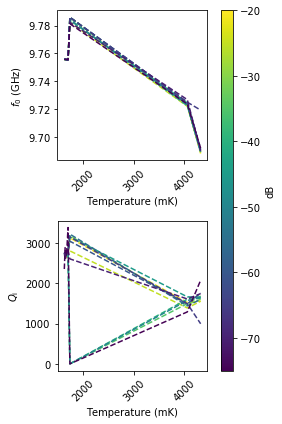

In [59]:
fig1c = plotResSweepParamsVsX(resSweeps['ETCH-NBND-1um'],
        xvals = 'temperature',
        fig_size = 3,
        plot_keys = ['f0', 'qi'],
        plot_labels = ['$f_0$ (GHz)',
                       '$Q_\mathrm{i}$'],
        unit_multipliers = [1e-9, 1],
        num_cols = 1,
        powers = [-20,-25,-30,-35,-40,-45,-50,-55,-60,-65,-70,-75],
        force_square=True)
#Uncomment to save the figure
#fig1c.savefig('fig1c.pdf')
plt.show()

In [60]:
import lmfit as lf

f0_params = lf.Parameters()

#Resonant frequency at zero temperature and zero power
f0_guess = resSweeps['ETCH-NBND-1um']['f0'].iloc[0, 0]
f0_params.add('f0',
              value = f0_guess,
              min = f0_guess*0.95,
              max = f0_guess*1.05)

#The loss roughly equivalent to tan delta
f0_params.add('Fd',
              value = 1e-6,
              min = 1e-8)

#The kinetic inductance fraction
f0_params.add('alpha',
              value = 0.005,
              min = 0,
              max = 1)

#The BCS energy gap at zero temperature
f0_params.add('delta0',
              value = 1.395,
              min = 1e-5,
              max = 1e01,)

#Qi needs all of the above parameters, plus a few more
qi_params = f0_params.copy()

#Q at zero power and zero temperature
qi_params.add('q0',
              value = 4e5,
              min = 1e4,
              max = 1e6)

#Critical power in W (modulo some calibration)
qi_params.add('Pc',
              value = 4,
              min = 0,
              max = 10000)

#Set the max temperature to fit to
max_fit_temp = 1.818

In [61]:
resSweeps['ETCH-NBND-1um'].do_lmfit(['qi'],
                            [scr.fitsSweep.qi_tlsAndMBT], #The model
                            [qi_params], #The paramters
                            min_pwr=-55, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [39]:
resSweeps['ETCH-NBND-1um'].do_lmfit(['qi'],
                            [scr.fitsSweep.qi_tlsAndMBT], #The model
                            [qi_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

resSweeps['ETCH-NBND-1um'].do_lmfit(['f0'],
                            [scr.fitsSweep.f0_tlsAndMBT], #The model
                            [f0_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

#Uncomment to look at the results of the fit
#lf.report_fit(resSweeps['RES-1'].lmfit_results['qi'])

ValueError: The input contains nan values

In [40]:
fig2a = scr.plotResSweep3D(resSweeps['ETCH-NBND-1um'],
                           plot_keys=['f0'],
                           max_temp=775,
                           unit_multipliers=[1e-9],
                           plot_labels = ['$f_0$ (GHz)'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_lmfits=True)

fig2b = scr.plotResSweep3D(resSweeps['ETCH-NBND-1um'],
                           plot_keys=['qi'],
                           max_temp=775,
                           unit_multipliers=[1e-6],
                           plot_labels = ['$Q_\mathrm{i}\\times10^{-6}$'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_lmfits=True)

#When the tick labels are really long, it's nice to push them out a little
#So they don't overlap with the label. This will be automatically handled
#in a future version.
fig2a.axes[0].tick_params(axis='z', pad=8)
fig2a.axes[0].zaxis.labelpad = 13

#Save figures
#fig2a.savefig('fig2a.pdf')
#fig2b.savefig('fig2b.pdf')
plt.show()

AssertionError: No fit to plot for f0.

In [41]:
resSweeps['ETCH-NBND-1um'].do_emcee(['f0'],
                            [scr.fitsSweep.f0_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})

resSweeps['ETCH-NBND-1um'].do_emcee(['qi'],
                            [scr.fitsSweep.qi_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})

AssertionError: Can't use lmfit params. They don't exist.

In [ ]:
#/Users/fcarter/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
#  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
#/Users/fcarter/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
#  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))

In [42]:
#Get the resulting MCMC chain for the 'f0' fit
f0_mcmc_chain = resSweeps['ETCH-NBND-1um'].emcee_results['f0'].flatchain.copy()

#Grab the best-fit values from the least-squares run
f0_lmfit_truths = [val for key, val in
    resSweeps['ETCH-NBND-1um'].lmfit_results['f0'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3]

for ix, m in enumerate(mults):
    f0_mcmc_chain.T.iloc[ix]/=m
    f0_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
f0_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)']

#Call pygtc to plot the figure
fig2c = pygtc.plotGTC(f0_mcmc_chain.iloc[:,1:],
                        truths = f0_lmfit_truths[1:],
                        paramNames=f0_labels[1:],
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6)

#Save figure
#fig2c.savefig('fig2c.pdf')

#Get the resulting MCMC chain for the 'qi' fit
qi_mcmc_chain = resSweeps['ETCH-NBND-1um'].emcee_results['qi'].flatchain.copy()
#Grab the best-fit values from the least-squares run
qi_lmfit_truths = [val for key, val in
    resSweeps['ETCH-NBND-1um'].lmfit_results['qi'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3, 1e6, 1e-6]

for ix, m in enumerate(mults):
    qi_mcmc_chain.T.iloc[ix]/=m
    qi_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
qi_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)',
            '$Q_\mathrm{i}(0)\\times10^{-6}$',
            '$P_\mathrm{c}$ ($\mu$W)']

#Call pygtc to plot the figure
fig2d = pygtc.plotGTC(qi_mcmc_chain.iloc[:,1:4],
                        truths = qi_lmfit_truths[1:4],
                        paramNames=qi_labels[1:4],
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6,
                        colorsOrder = 'greens')


#Save figure
#fig2d.savefig('fig2d.pdf')
plt.show()

KeyError: 'f0'

In [ ]:
#Run the joint fit using the least-squares engine
resSweeps['RES-1'].do_lmfit(['f0', 'qi'],
                            [scr.fitsSweep.f0_tlsAndMBT, scr.fitsSweep.qi_tlsAndMBT], #The model
                            [f0_params, qi_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)
plt.show()

In [ ]:
resSweeps['RES-1'].do_emcee(['f0', 'qi'],
                            [scr.fitsSweep.f0_tlsAndMBT, scr.fitsSweep.qi_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})
plt.show()

In [ ]:
#Get the resulting MCMC chain for the 'qi' fit
f0qi_mcmc_chain = resSweeps['RES-1'].emcee_joint_results['f0+qi'].flatchain.copy()

#Grab the best-fit values from the least-squares run
f0qi_lmfit_truths = [val for key, val in
    resSweeps['RES-1'].lmfit_joint_results['f0+qi'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3, 1e6, 1e-6]

for ix, m in enumerate(mults):
    f0qi_mcmc_chain.T.iloc[ix]/=m
    f0qi_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
f0qi_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)',
            '$Q_\mathrm{i}(0)\\times10^{-6}$',
            '$P_\mathrm{c}$ ($\mu$W)']

#Call pygtc to plot the figure
fig2d = pygtc.plotGTC(f0qi_mcmc_chain,
                        truths=f0qi_lmfit_truths,
                        paramNames=f0qi_labels,
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6)

In [ ]:
fig2e = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['f0'],
                           max_temp=775,
                           unit_multipliers=[1e-9],
                           plot_labels = ['$f_0$ (GHz)'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_fits=['lmfit_joint_f0+qi'])

fig2f = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['qi'],
                           max_temp=775,
                           unit_multipliers=[1e-6],
                           plot_labels = ['$Q_\mathrm{i}\\times10^{-6}$'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_fits=['lmfit_joint_f0+qi'])

#When the tick labels are really long, it's nice to push them out a little
#So they don't overlap with the label. This will be automatically handled
#in a future version.
fig2e.axes[0].tick_params(axis='z', pad=8)
fig2e.axes[0].zaxis.labelpad = 13
plt.show()